# TARDIGRADE Analysis

In [1]:
import getpass
import sys
import os
if getpass.getuser() == 'mshaaban':
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai')
    jtplot.style(ticks=True, grid=False, figsize=(8, 4.5))
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy import units as u
from astropy import constants as const
import pandas as pd
from functools import reduce

In [2]:
base_path = "/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/"

## Setup

### Notes
Here we present a tool to use to quickly look up notes on what was going on in the experiment as a function of time.

In [3]:
notes = pd.read_csv(base_path+"notes.csv")

def get_note(time,n=3):
    """A function that given a unix time stamp will return the n notes nearest to it in time"""
    args = (notes['Unix Timestamp'] - time).abs().argsort()[:n]
    return notes.iloc[args]

#### Sample Usage
- Begin by plotting beam power as a function of time. We idnetify interesting feature e.g. prolonged low power area around 1.65505e9.
- use `get_note(time,number of notes to show)` to get some notes nearest to the time of interest
- use `get_note()['Notes'][n]` to get more information on the nth note where n is the index in the table NOT the ordered index for the given size

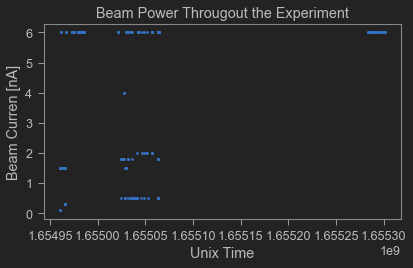

In [4]:
plt.plot(notes["Unix Timestamp"], notes["Beam Current [nA]"],'.')
plt.title("Beam Power Througout the Experiment")
plt.ylabel("Beam Curren [nA]")
plt.xlabel("Unix Time");

In [5]:
get_note(1.65505e9,5)

,Device,Short Name,Type of Test,Date,Time [PST],Unix Timestamp,Notes,Beam Current [nA],Scale Factor
142,Power Switching Relay Board - custom,psrb,Slow aging to 1650 rad,"June 12, 2022",16:23,1655050980,locking up and requesting 2nA => 500 count/s,2.0,1
141,USB to serial converter - FTDI chip,usb2serial,Slow aging to 1650 rad,"June 12, 2022",15:46,1655048760,Go up to 6 nA => 1500 count/s\r\nCompletely f...,6.0,1
143,Power Switching Relay Board - custom,psrb,Slow aging to 1650 rad,"June 12, 2022",16:30,1655051400,Shutter open beam started \r\nBoring so far 2 ...,2.0,1
140,USB to serial converter - FTDI chip,usb2serial,Slow aging to 1650 rad,"June 12, 2022",15:42,1655048520,Go up to 2 nA => 500 count /s\r\nNo errors up ...,2.0,1
144,Power Switching Relay Board - custom,psrb,Slow aging to 1650 rad,"June 12, 2022",16:33,1655051580,request 6nA => 1400 count/s\r\nStill boring,6.0,1


In [6]:
get_note(1.65505e9,5)['Notes'][143]

'Shutter open beam started \r\nBoring so far 2 minutes into it'

## Data

Due to the fact that each device had its own flavour of data for the most part each device will have to be handled indvisually with regards to data upload. In this section we hadle each case seprately. Due to RAM requirments we recommend you only load in the data that you need for your analysis.

In [97]:
def smart_hist(img, title="", bins=10000, sigma=3, label="", report=True,norm=False):
    """Simple tool to plot histogram of a 2D array image

    Args:
        img (1-2D array):
            The image array
        title (str, optional):
            Figure title. Defaults to "".
        bins (int, optional):
            Number of bins in histogram. Defaults to 10000.
        sigma (int, optional):
            Sigma clipping of the x axis. Defaults to 1.
        nfig (bool, optional):
            If True create a new figure, if False overlay on previous figure.
            Defaults to True.
        label (str, optional):
            Label of the plot if overlaying multiple figures. Defaults to "".
        report (bool, optional):
            If True report the image mean, median and std. Defaults to True.
    """
    img = np.nan_to_num(img,nan=np.mean(img))
    m = np.mean(img)
    s = np.std(img)
    hist, edge = np.histogram(img, bins=bins)
    if norm:
        hist, edge = np.histogram(img, bins=bins,density=True)
    plt.plot(edge[1:], hist, label=label)
    plt.xlim([m - (sigma * s), m + (sigma * s)])
    plt.title(title)
    plt.legend()
    temp = sorted(hist, key=lambda x: abs(x - np.max(hist) / 2))
    print("Peak =", np.max(hist),
          "FWHM = ", np.abs(
              edge[np.where(hist == temp[0])] - edge
              [np.where(hist == temp[1])])[0],)
    if report:
        print("mean:",m,"median:", np.median(img), "std:",s)
        
def read_merge_all(dflist, path, cond=lambda a : True):
    for file in os.listdir(path):
        if os.path.isfile(path+file):
            if cond(file):
                print("reading",file)
                dflist.append(pd.read_csv(path+file))
                
    dfs = [df.set_index('time') for df in dflist]
    return pd.concat(dfs)

### Arduino

In [56]:
def load_ard_data(path,df=None):
    """Function to load arduino data spit out by the reader script and turn it into a usable pandas data frame"""
    if df is None:
        # create temporary data frame
        df = pd.read_csv(path)
        df.read_bytes = df.read_bytes.str.split(" ")
    
    # process data frame into usable format by breaking things 
    #like pwm_100: 140 into label and value
    vals = []
    label = []
    for mem in df.read_bytes:
        if len(mem) > 1:
            label.append(mem[0])
            vals.append(mem[1].split("\r")[0])

    # Create dictionary that maps the unique labels to all their values
    vals = np.array(vals).astype(float)
    label = np.array(label)
    dat = {}
    # get the time by subsampling all recorded times by the number of labels
    dat['time'] = np.array(df.time)[0:-1:len(set(label))]
    
    for l in set(label):
        dat[l] = vals[label==l]
    
    # Convert that dictionary into a pandas data frame for ease of use
    return pd.DataFrame.from_dict(dict([ (k,pd.Series(v)) for k,v in dat.items() ]))#.fillna(-1.0)

#### Example

In [57]:
path = base_path+"arduino"
ard_slow = load_ard_data(path+"/data/slow_dose/ard1655071123.6531866.csv")
ard_fast = load_ard_data(path+"/data/fast_dose/ard1655311267.1804419.csv")
ard_pre = load_ard_data(path+"/data/pre_beam/ard1654906400.557813.csv")

Peak = 0.6629125408191016 FWHM =  6.900000000000034
mean: 361.19794642375894 median: 359.0 std: 3.1187071375251336
Peak = 0.6602718596356055 FWHM =  6.900000000000034
mean: 361.2018626653854 median: 359.0 std: 3.1230695507993813
Peak = 0.6611178921671919 FWHM =  6.900000000000034
mean: 361.2014359470797 median: 359.0 std: 3.1237261287455063


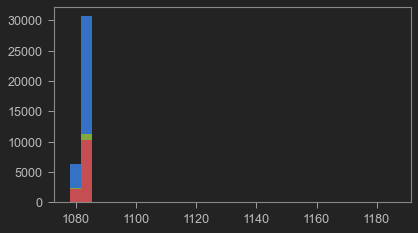

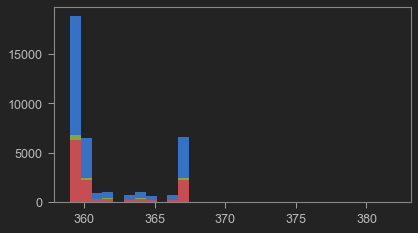

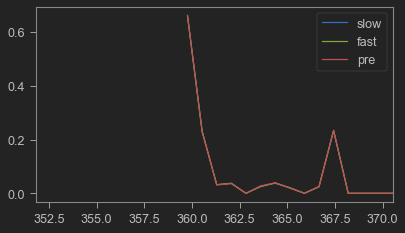

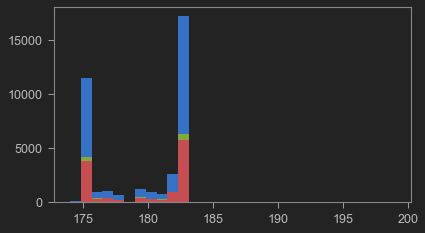

In [98]:
plt.hist(ard_slow['pwm_150:'],bins=30);
plt.hist(ard_fast['pwm_150:'],bins=30);
plt.hist(ard_pre['pwm_150:'],bins=30);

plt.figure()
plt.hist(ard_slow['pwm_100:'],bins=30);
plt.hist(ard_fast['pwm_100:'],bins=30);
plt.hist(ard_pre['pwm_100:'],bins=30);

plt.figure()
smart_hist(ard_slow['pwm_100:'],bins=30,label="slow",norm=True);
smart_hist(ard_fast['pwm_100:'],bins=30,label="fast",norm=True);
smart_hist(ard_pre['pwm_100:'],bins=30,label="pre",norm=True);

plt.figure()
plt.hist(ard_slow['pwm_50:'],bins=30);
plt.hist(ard_fast['pwm_50:'],bins=30);
plt.hist(ard_pre['pwm_50:'],bins=30);

### Ethernet Switch